In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [3]:
code_dir = "/home/mlmi-2020/jz522/localisation_from_image_project/code_reg_and_clas"
import os, sys
if code_dir not in sys.path:
    sys.path.append(code_dir)

## load data

In [4]:
# load dataset
data_dir = "/data/cornucopia/jz522/localisation_project/DS_003_JDB-Full/coordinates_256_512__141_classes__simple_whitening/"
dataset_size = 370
start = 0


images = np.zeros((dataset_size, 256, 512, 3))
oracle_global_coords = np.zeros((dataset_size, 256, 512, 3))
regions = np.zeros((dataset_size, 256, 512, 1))
local_coords = np.zeros((dataset_size, 256, 512, 3))
masks = np.zeros((dataset_size, 256, 512, 1))

for i in tqdm(np.arange(start, start+dataset_size)):
    data = np.load(data_dir + f"{i+1:04}_rendered.png_config.npz")

    
    images[i] = data['image_colors']
    oracle_global_coords[i] = data['points_3d_world']
    regions[i,:,:,0] = data['points_region_class']
    local_coords[i] = data['local_scene_coords']
    masks[i,:,:,0] = data['mask']
    
    if i == 0:
        std_vec = data['std_vec']
        mean_vec = data['mean_vec']

100%|██████████| 370/370 [00:05<00:00, 66.78it/s]


## load model

In [5]:
from utilis.experiment_utilis import combined_loss_weighted
import tensorflow as tf
from tensorflow import keras 

# load model
checkpoint_dir = "/data/cornucopia/jz522/experiments/2021-05-18/FPN_resnet_bs16_LR5e-4_w10-1_simple_whitenning_2021-05-18_13:32:41/saved_model/my_model"
model = keras.models.load_model(checkpoint_dir, compile=False)
model.compile(optimizer=keras.optimizers.Adam(1e-4), loss=combined_loss_weighted([10, 1]))

## predict local scene coords

**using stiching**

In [6]:
# from utilis.utilis import crop #, stich

# start_row = [0,0,0,32,32,32]
# start_col = [0,224,448,0,224,448]

# croped_image = crop(images[0:1], start_row, start_col)
# croped_mask = crop(masks[0:1], start_row, start_col)
# pred_local_coords = model.predict([croped_image, croped_mask]) 

**feeding entire 256x512 image**

In [7]:
pred_local_coords = np.zeros((dataset_size, 256, 512, 144))
for i in tqdm(range(dataset_size)):
    pred_local_coords[i] = np.array(model.predict_on_batch([images[i:i+1], masks[i:i+1]]))

  0%|          | 0/370 [00:00<?, ?it/s]

100%|██████████| 370/370 [00:44<00:00,  8.37it/s]


In [8]:
# predict loal scene coords
# pred_local_coords = model.predict([images, masks]) 

# unwhiten local scene coords -> get world scene coords

In [9]:
# 1. convert regions to their mean centers
pred_local_coords_flat = np.reshape(pred_local_coords[:,:,:,:3], (-1,3))
pred_regions = np.argmax(pred_local_coords[:,:,:,3:], axis=-1)
pred_regions_flat = np.reshape(pred_regions, (-1)).astype(int)
pred_global_coords = np.zeros((dataset_size*256*512,3))

# 2. unwhitten local coordinates
for region in tqdm(np.unique(pred_regions_flat)):
    region_coords = pred_local_coords_flat[pred_regions_flat == region]
    unwhite_loc_coords = (region_coords * std_vec[region]) + mean_vec[region]

    pred_global_coords[pred_regions_flat == region] = unwhite_loc_coords
    
pred_global_coords = np.reshape(pred_global_coords, (dataset_size, 256, 512, 3))

100%|██████████| 141/141 [00:50<00:00,  2.78it/s]


## inspect

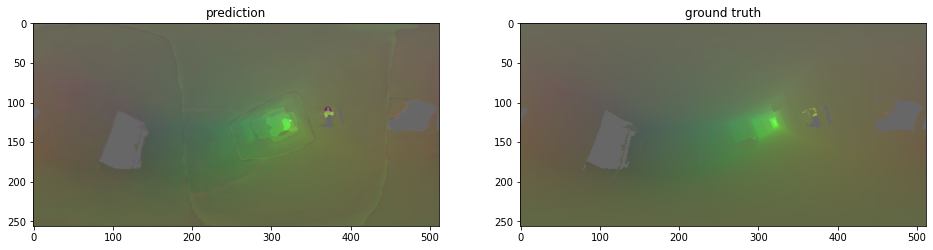

In [10]:
image_ID = 2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
max_ = max(max(pred_global_coords[image_ID].flatten()), max(oracle_global_coords[image_ID].flatten()))
min_ = min(min(pred_global_coords[image_ID].flatten()), min(oracle_global_coords[image_ID].flatten()))

pred_norm = (pred_global_coords[image_ID] - min_) / (max_ - min_)
ax1.imshow(pred_norm)
ax1.set_title('prediction')

gt_norm = (oracle_global_coords[image_ID] - min_) / (max_ - min_)
ax2.imshow(gt_norm)
ax2.set_title('ground truth')
plt.show()

## get pixelwise MSE error

In [11]:
colormap = np.random.randint(0, high=256, size=(141,3), dtype=int)

In [12]:
def get_color_map(regions, colormap):

    reg_flat = np.reshape(regions, (-1)).astype(int)
    colored_regions_flat = colormap[reg_flat]
    colored_regions = np.reshape(colored_regions_flat, (256,512,3))
    return colored_regions

In [13]:
# from utilis.utilis import get_color_map

def visualise_error(image_ID):
    pixelwise_MSE = np.mean(np.square((pred_global_coords[image_ID]*masks[image_ID]) - (oracle_global_coords[image_ID]*masks[image_ID])), axis=-1)
    pixelwise_local_MSE = np.mean(np.square((pred_local_coords[image_ID,:,:,:3]*masks[image_ID]) - (local_coords[image_ID,:,:,:3]*masks[image_ID])), axis=-1)
    
    # IMAGE AND MASK
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(18,15))
    
    ax1.imshow(images[image_ID])
    ax1.set_title(f'Image ID: {image_ID+1:04}')
    
    ax2.imshow(masks[image_ID])
    ax2.set_title('GT mask')
      
    colored_regions = get_color_map(regions[image_ID], colormap)
    pred_colored_regions = get_color_map(pred_regions[image_ID], colormap)
    ax3.imshow(pred_colored_regions)
    ax3.set_title('Pred regions')
    
    ax4.imshow(np.abs(pred_colored_regions - colored_regions))
    ax4.set_title('Region Pred. Error')
    
    pixelwise_local_MSE_cap_1 = np.where(pixelwise_local_MSE < 1, pixelwise_local_MSE, 1)
    im5 = ax5.imshow(pixelwise_local_MSE_cap_1)
    ax5.set_title("Local -capped at MSE = 1")
    divider = make_axes_locatable(ax5)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = fig.colorbar(im5, cax=cax)    

    pixelwise_MSE_cap_1 = np.where(pixelwise_MSE < 1, pixelwise_MSE, 1)
    im6 = ax6.imshow(pixelwise_MSE_cap_1)
    ax6.set_title("Global - capped at MSE = 1")
    divider = make_axes_locatable(ax6)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = fig.colorbar(im6, cax=cax)

    return fig

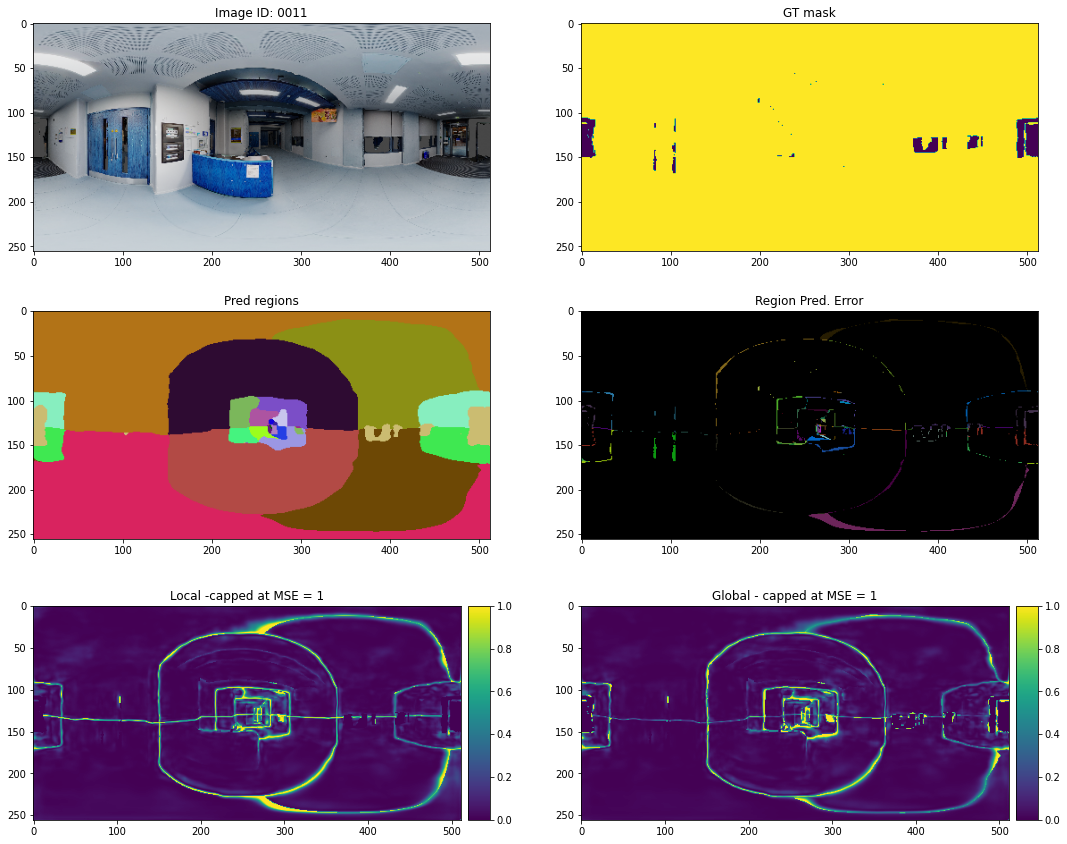

In [14]:
fig = visualise_error(10)
plt.show()

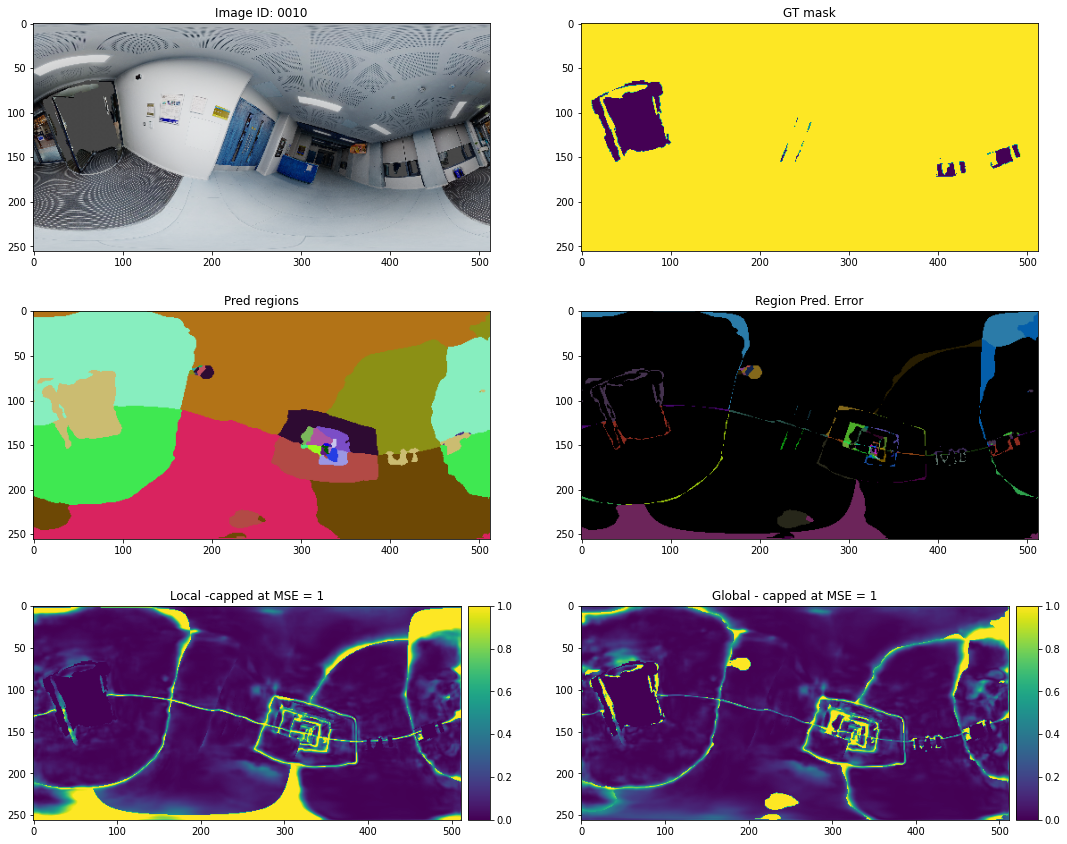

In [15]:
fig = visualise_error(9)
plt.show()

# would be useful to colorcode magnitudes of errors. It's informative that MSE > 1 but it would be more informative to know by how much.

## save train and validation error maps

In [16]:
# load json with data split
data_partition_path = "/data/cornucopia/jz522/experiments/2021-05-18/FPN_resnet_bs16_LR5e-4_w10-1_simple_whitenning_2021-05-18_13:32:41/data_partition.json"

data_partition_file = open(data_partition_path)
data_partition = json.load(data_partition_file)
data_partition_file.close()

In [17]:
# train
train_indexes = np.zeros(len(data_partition['train']), dtype=int)
for ind, image_name in enumerate(data_partition['train']):
    train_indexes[ind] = int(image_name.split('/')[-1].split("_")[0])
    
# val
val_indexes = np.empty(len(data_partition['validation']), dtype=int)
for ind, image_name in enumerate(data_partition['validation']):
    val_indexes[ind] = int(image_name.split('/')[-1].split("_")[0])

In [20]:
from utilis.utilis import make_dir

save_dir = "/data/cornucopia/jz522/experiments/model_visualisation/reg_clas_model__w10-1__SW__18_05_2021/"
make_dir(save_dir + "train/")
make_dir(save_dir + "val/")

for ind in tqdm(train_indexes):
    fig = visualise_error(ind-1)
    fig.savefig(save_dir + "train/" f"{ind:04}", facecolor='w')
    plt.close(fig)
    
for ind in tqdm(val_indexes):
    fig = visualise_error(ind-1)
    fig.savefig(save_dir + "val/" f"{ind:04}", facecolor='w')
    plt.close(fig)

100%|██████████| 37/37 [00:30<00:00,  1.21it/s]


## get PLY file with all points

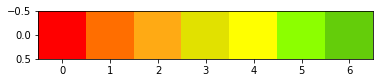

In [21]:
colors = np.array([[255, 0 , 0], [255, 110, 0], [255, 170, 20], [225,225,0], [255,255,0], [140,255,0], [100,205,10]])
colors = np.reshape(colors, (1, colors.shape[0], 3))
plt.imshow(colors)
plt.show()

colors = np.reshape(colors, (-1,3))
e = [10,3,1,0.5,0.2,0.05,0.01]

In [22]:
all_images_MSE = np.mean(np.square((pred_global_coords*masks) - (oracle_global_coords*masks)), axis=-1)

vertices = np.reshape(oracle_global_coords, (-1,3))
MSE_values = np.reshape(all_images_MSE, (-1))

In [23]:
vertices_colors = [colors[0] if i > e[0] else 
                   colors[1] if i > e[1] else
                   colors[2] if i > e[2] else
                   colors[3] if i > e[3] else
                   colors[4] if i > e[4] else
                   colors[5] if i > e[5] else
                   colors[6] for i in tqdm(MSE_values)]

100%|██████████| 48496640/48496640 [01:25<00:00, 567773.60it/s]


In [24]:
vertices_colors = np.array(vertices_colors)
vertices_colors.shape

(48496640, 3)

In [25]:
vertices.shape

(48496640, 3)

In [26]:
from utilis.utilis import writePlyFile

file_name = "MSE_point_cloud_sampled_100.ply"

writePlyFile(save_dir, file_name, vertices, vertices_colors, sample=100)

## inspect

In [ ]:
# inspect where the model makes errors
#   Q: what object categories does the model poorly predict on?
#   Q: what parts of the building does it poorly predict on?
#   Q: which cameras does the model predict worse on?
#   Q: how does positioning of validation cameras affects error?
#   Q: 